# Pre-Processing & Model First Pass

Within this section I'll preprocess and model my data.

Before I model the data we finalized in the last section, I'll need to make sure all of the data are ready to be modeled. I'll preprocess the data which includes onehotencoding my categorical features, scale any continuous features, and remove unencessary features to create a model ready dataframe.

### Library Imports 

In [1]:
import numpy as np
import requests
import pickle
import time
import seaborn as sns
import mlflow

import pandas as pd
from pandas import json_normalize

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import pycaret
from pycaret.regression import *
from pycaret.regression import RegressionExperiment

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import shapiro, skew, kurtosis
from scipy.stats import boxcox

import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from kneed import KneeLocator

In [2]:
pd.set_option('display.max_columns', None)
pyo.init_notebook_mode(connected=True)

In [3]:
print(mlflow.list_experiments())

[<Experiment: artifact_location='file:///Users/ryan/GA/Portfolio/TransitCostEstimator/mlruns/1', creation_time=1707431296683, experiment_id='1', last_update_time=1707431296683, lifecycle_stage='active', name='train_nonlog', tags={}>]


### Data Imports

In [4]:
with open('pickles/df.pkl', 'rb') as f:
    df = pickle.load(f)

In [5]:
df_cost = df

In [6]:
df.shape

(1604, 73)

As noted above, there are several binary features in this dataset. I'll include these features within the continuous features as the downside for scaling a binary feature would simply be a loss of interpretability. 

#### Distributions

I'll use the Shapiro-Wilk test to gauge the normality of my data after the log transform. A value less than .05 indicates that the feature is normally distributed.

In [7]:
continuous_features = df.select_dtypes(include=['float64', 'int64']).columns

In [8]:
shapiro_results = []
for feature in continuous_features:
    stat, p_value = shapiro(df[feature].dropna())
    shapiro_results.append({'Feature': feature, 'W Statistic': stat, 'P-Value': p_value})

shapiro_results_df = pd.DataFrame(shapiro_results)

In [9]:
shapiro_results_df

,Feature,W Statistic,P-Value
0,start_year,0.910435,9.875695e-30
1,end_year,0.908755,5.794054e-30
2,rr?,0.219849,0.000000e+00
3,length,0.118759,0.000000e+00
4,tunnel,0.705506,0.000000e+00
...,...,...,...
62,urban?,0.629728,0.000000e+00
63,rental_yield,0.786343,1.391209e-41
64,price_rent_ratio,0.950773,8.864681e-23
65,union_density,0.827311,1.726565e-38


In [10]:
fig = px.histogram(df, x="cost_real_2023")
fig.show()

This distribution shows that we are dealing with skewed distributions. I'll investigate this further and identify a transformation to apply in the next steps.

### Error & Anomoly Detection

This section focuses on outlier detection to improve our dataset's quality for subsequent modeling. We will use DBSCAN and Isolation Forest algorithms for their proficiency in identifying data anomalies. Complementing these, Z-scores and IQR methods will serve as statistical measures to flag data points that deviate significantly from the norm. 

Together, these strategies will ensure a cleaner, more accurate dataset for our predictive analysis.

#### IQR values

Zscores, another outlier identification tool, are most beneficial when the underlying features are normally distributed. Since the target feature (cost_real_2023) and the cost_km_2023 feature were not logged and have some skewness, I'll use IQR plots to evaluate these features.

To determine which features to include in the outlier analysis, I'll look at the skewness and variance of the continious features and use those metrics as a base for the features to include in the IQR.

In [11]:
df['length'].describe()

count    1604.000000
mean       18.807215
std        58.943534
min         0.500000
25%         5.297500
50%        12.600000
75%        23.946807
max      2265.000000
Name: length, dtype: float64

In [12]:
df = df[df['length']<80]

### Severe Outliers

Before proceeding with more robust methods for identifying outliers, I'd like to first remove any clear outliers that could skew the analysis done in the next steps. I'll be plotting the data in a scatter to see if there are individual points that differ enough from the mean to remove them from the dataset.

In [13]:
fig = px.scatter(df, x='length', y='cost_real_2023',
                 color='train_type',
                 title='Length (log) vs Target')
fig.show()

Since we can immediately see 4 datapoints differ significantly enough from the rest of the group, I'll add these datapoints to the outliers list.

In [14]:
df[df['cost_real_2023'] >240000]

,country,city,start_year,end_year,rr?,length,tunnel,elevated,at_grade,stations,max_speed,track_gauge,overhead?,anglo,cost_real_2023,cost_km_2023,train_type,project_type,duration,country_pop_den,region,sub_region,area_km,population,calculated_population,city_density,per_below_line,reporting_gdp,wrb_class_value,prob_Ferralsols,prob_Acrisols,prob_Andosols,prob_Cryosols,prob_Cambisols,prob_Gleysols,prob_Kastanozems,prob_Albeluvisols,prob_Calcisols,prob_Chernozems,prob_Durisols,prob_Gypsisols,prob_Fluvisols,prob_Alisols,prob_Planosols,prob_Arenosols,prob_Plinthosols,prob_Luvisols,prob_Umbrisols,prob_Podzols,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,elevation,tavg,tmin,tmax,prcp,land_cost_year,price_income_ratio,mortgage_perc_income,affordability_index,urban?,rental_yield,price_rent_ratio,union_density,stations_per_km
1400,AR,Buenos Aires,1990,1995,1.0,15.5,0.0,0.0,15.5,11.0,30.0,1435.0,1,0,3.165520e+05,20422.70988,Light Rail,New,5,12.433721,Americas,Latin America and the Caribbean,3437.00,16710000.0,1.354780e+07,3941.752568,4.770097,9412.994813,20.0,2.0,5.0,0.0,0.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,18.0,3.0,0.0,4.0,0.0,1.0,1.0,11.0,2.0,20.0,3.0,5.0,2.0,5.0,3.0,0.0,16.0,18.350,13.800,22.900000,102.916667,1993,9,1669,0,1,1,13,33.477516,0.709677
1571,VE,Valencia,1994,2006,0.0,4.3,4.3,0.0,0.0,5.0,60.0,1435.0,1,0,2.717232e+05,63191.43715,Light Rail,New,12,27.694268,Americas,Latin America and the Caribbean,623.00,1484430.0,1.216556e+06,1952.739002,51.160678,17364.320000,6.0,2.0,5.0,2.0,0.0,14.0,5.0,0.0,0.0,1.0,0.0,1.0,0.0,14.0,4.0,1.0,3.0,1.0,6.0,0.0,0.0,1.0,10.0,10.0,3.0,4.0,2.0,0.0,5.0,1.0,0.0,459.0,26.600,22.900,30.300000,126.250000,2000,7,239,1,0,19,6,0.200000,1.162791
1586,BY,Minsk,2014,2023,0.0,17.2,17.2,0.0,0.0,7.0,80.0,1520.0,0,0,2.088946e+06,121450.32780,Streetcar,New,9,46.410751,Europe,Eastern Europe,409.53,2009786.0,2.001380e+06,4887.017320,4.103668,5967.052204,1.0,0.0,0.0,0.0,0.0,6.0,9.0,3.0,14.0,0.0,6.0,0.0,0.0,7.0,0.0,0.0,5.0,0.0,14.0,0.0,8.0,2.0,1.0,0.0,12.0,3.0,0.0,0.0,5.0,0.0,2.0,226.0,5.975,2.075,9.858333,56.416667,2019,14,212,0,1,4,21,10.000000,0.406977


In [15]:
df = df[df['cost_real_2023'] < 240000]

Additionally, there's a cluster of data on the x-axis that is separated from the rest of the cluster. I'll adjust the dataset once more to remove longer than normal projects. These projects aren't inherently outliers, but they pose the risk of interfering with the models ability to predict the cost of shorter projects.

In [16]:
fig = px.scatter(df, x='length', y='cost_km_2023',
                 color='train_type',
                 title='Length (log) vs Cost Per Km')
fig.show()

Looking at the cost per km for different train types, there's two types of apparent outliers. First the Monorail grouping is clear, save for one outlier. I'll remove this singular point.

Second there are several outliers for the streetcar data that are outside of the normal range for a streetcar.

In [17]:
streetcar_outliers = df[(df['train_type']=='Streetcar') & (df['cost_km_2023']>=500)].index

In [18]:
monorail_outliers = df[(df['train_type']=='Monorail/APM') & (df['cost_km_2023']>=2000)].index

In [19]:
MRT_outliers = df[(df['train_type']=='MRT') & (df['cost_km_2023']>=1500)].index

In [20]:
df = df.drop(index = streetcar_outliers)
df = df.drop(index = monorail_outliers)
df = df.drop(index = MRT_outliers)

Finally, I'll look at the overall cost of the projects to remove any values that are clear outliers from the rest of the cluster.

In [21]:
fig = px.scatter(df, x='length', y='cost_real_2023',
                 color='train_type',
                 title='Length (log) vs Cost Total')
fig.show()

Most of the values are well grouped and there is a sparsely populated grouping of values above 29k. I'll use this as a relatively arbitrary cutoff and remove these values.

In [22]:
MRT_cost_outliers = df[(df['train_type']=='MRT') & (df['cost_real_2023']>=20000)].index
LR_cost_outliers = df[(df['train_type']=='Light Rail') & (df['cost_real_2023']>=20000)].index
streetcar_cost_outliers = df[(df['train_type']=='Streetcar') & (df['cost_real_2023']>=3000)].index
mono_cost_outliers = df[(df['train_type']=='Monorail/APM') & (df['cost_real_2023']>=10000)].index

In [23]:
df = df.drop(index = MRT_cost_outliers)
df = df.drop(index = LR_cost_outliers)
df = df.drop(index = streetcar_cost_outliers)
df = df.drop(index = mono_cost_outliers)

In [24]:
fig = px.scatter(df, x='length', y='cost_real_2023',
                 color='train_type',
                 title='Length (log) vs Cost Total')
fig.show()

In [25]:
fig = px.scatter(df, x='duration', y='cost_real_2023',
                 color='train_type',
                 title='Length (log) vs Cost Total')
fig.show()

In [26]:
df_cleaned = df

### Box Cox Transformations

Based on the distributions shown in the EDA section, the target variable (cost) may benefit from a transformation. The skewed nature of cost predictions, and of train projects specifically, means that the data will contain natural outliers. In the previous sections I iterated through modelling and evaluation of outliers. By transforming the data here, after removing outliers, It's more likely that these natural outliers will be ignored and I'll keep more important information. For instance, a tram project in Poland will cost significantly less than an MRT in Taiwan. Neither are outliers, but both appear to be based on the distribution of values.

The Box Cox transformation simply shortens the distribution of values, reducing the impact of the natural variance present in the data. Since I have removed drastic outliers from the dataset, I can now expect that the resulting distribution of the data will be normal.

In [27]:
skewness = df.select_dtypes(include=[np.number]).apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
significant_skew = skewness[abs(skewness) > 0.7].index

In [28]:
exclusions = ("prob_", "lat", "lng", "overhead", "anglo", "time_diff", "start_", "end_", "rr?","tmin",'cost_km_2023')
filtered_features = [feature for feature in significant_skew if not feature.startswith(exclusions)]

In [29]:
lambdas_dict = {}
for feature in filtered_features:
    df[f'{feature}_transformed'], fitted_lambda = boxcox(df[feature] + 1)
    lambdas_dict[f'{feature}_transformed'] = fitted_lambda

In [30]:
lambdas_dict

{'city_density_transformed': 0.00031072693281113123,
 'stations_per_km_transformed': -0.843917432145793,
 'country_pop_den_transformed': -0.024148703916825665,
 'mortgage_perc_income_transformed': 0.43630199186416435,
 'elevation_transformed': 0.006618194432501763,
 'at_grade_transformed': -0.8989359033386887,
 'elevated_transformed': -1.2725893998696707,
 'area_km_transformed': 0.12768101168676993,
 'affordability_index_transformed': -1.142273844158675,
 'duration_transformed': -0.05903700480784776,
 'rental_yield_transformed': -0.3544317972791052,
 'union_density_transformed': 0.44390077005765416,
 'cost_real_2023_transformed': 0.20433889595232582,
 'tunnel_transformed': -0.12182275409689616,
 'length_transformed': 0.11027835330289565,
 'stations_transformed': 0.21931785374583201,
 'population_transformed': 0.21978946893934576,
 'calculated_population_transformed': 0.2270007068567844,
 'per_below_line_transformed': 0.01817407072210716,
 'max_speed_transformed': 0.7503758782047558,
 '

In [31]:
cat_feats = ['country', 'city', 'region', 'sub_region', 'train_type', 'wrb_class_value', 'urban?', 'rr?','project_type']
drop_cols = ['country','city','cost_transformed','currency','cost_km_transformed','cost_real_transformed','lat','lng','wrb_class_name']

In [32]:
features_with_boxcox_transform = [feature[:-12] for feature in df.columns if feature.endswith('_transformed')]
features_to_drop = set(feature for feature in features_with_boxcox_transform if feature not in cat_feats)

features_to_drop.discard('cost_real_2023')
features_to_drop.discard('start_year')
features_to_drop.discard('end_year')
features_to_drop.discard('cost_km_2023')


cost_features_to_drop = set(col for col in df.columns if "cost" in col and col != 'cost_real_2023_transformed')
cost_features_to_drop.discard('cost_km_2023')

all_features_to_drop = features_to_drop.union(cost_features_to_drop).union(drop_cols)

In [33]:
all_features_to_drop
df_adj = df.drop(columns=all_features_to_drop, errors='ignore')

### Target feature Box Cox

In [35]:
fig = px.histogram(df_adj, x="cost_real_2023_transformed")
fig.show()

In [36]:
df= df_adj

#### DBSCAN

Within DBSCAN I'll be dummying the categorical features. This will let me look at the importance of train type and region as it pertains to the predictors in the dataset.

In [38]:
cat_feats = ['region','sub_region','train_type','project_type']
df_dummied_db = pd.get_dummies(df, columns=cat_feats)
continuous_features = df.drop(columns=['cost_real_2023_transformed','cost_km_2023'] + cat_feats).columns.tolist()
dummy_columns = [col for col in df_dummied_db.columns if col not in df.columns]

features = continuous_features + dummy_columns

#### Programmatically Determining Epsilon

In [39]:
X_db = df_dummied_db[features]

scaler = StandardScaler()
X_db_scaled = scaler.fit_transform(X_db)

In [40]:
min_samples = 9
k = min_samples - 1

nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_db_scaled)
distances, indices = nn.kneighbors(X_db_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:, -1]

kneedle = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
eps_value = distances[kneedle.elbow]
eps_value

13.729988564079925

#### Running DBScan

In [41]:
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
clusters = dbscan.fit_predict(X_db_scaled)

In [42]:
df_dummied_db['cluster'] = clusters

In [43]:
outlier_indexes = np.where(clusters == -1)[0]

In [44]:
dbscan_outliers = np.where(clusters == -1)[0]
dbscan_outliers_list = X_db.iloc[outlier_indexes].index.tolist()
dbscan_outliers_set = set(dbscan_outliers_list)

In [45]:
len(dbscan_outliers_list)

14

#### Visualizing DBScan

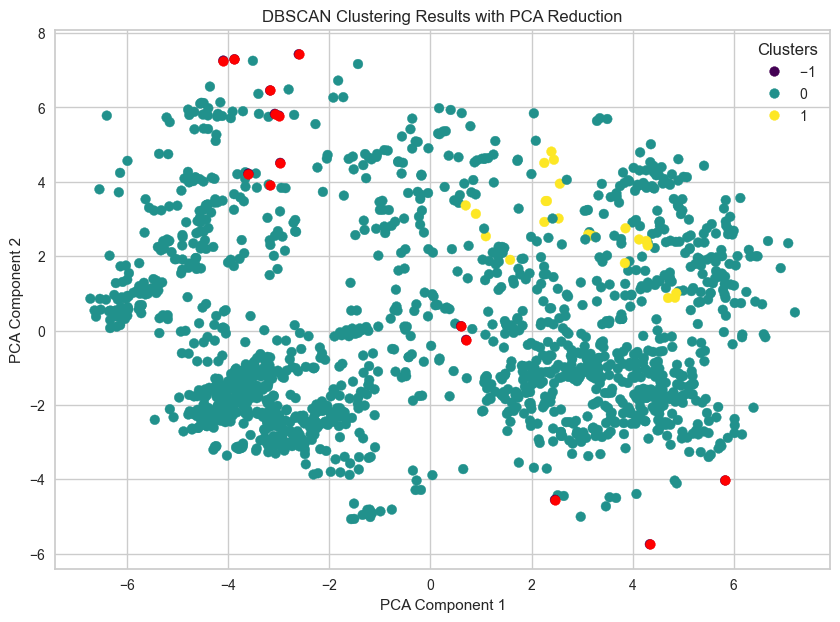

In [46]:
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_db_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', label=clusters)
plt.title('DBSCAN Clustering Results with PCA Reduction')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Highlight outliers
outlier_indices = np.where(clusters == -1)
plt.scatter(X_pca[outlier_indices, 0], X_pca[outlier_indices, 1], color='red', label='Outliers')

# Add a legend
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

In [47]:
mask = clusters != -1
clustered_data = X_db_scaled[mask]
cluster_labels = clusters[mask]

In [48]:
silhouette_avg = silhouette_score(clustered_data, cluster_labels)
print(f'Average silhouette score for clustered data: {silhouette_avg}')

Average silhouette score for clustered data: 0.28987250687479676


### List of Outlier Indices Identified by All Methods

In [49]:
all_outliers_combined = dbscan_outliers_set
all_outliers_combined_list = list(all_outliers_combined)

In [50]:
len(all_outliers_combined_list)

14

In [51]:
df.shape

(1544, 70)

#### Dropping Outliers

In [52]:
df_cleaned = df[~df.index.isin(all_outliers_combined_list)]
df_cleaned.drop(columns= ['cost_km_2023'],inplace=True)

In [53]:
df_cleaned.shape

(1530, 69)

### Isolation Forest with Dummied Categorical Features

In [55]:
cat_feats = ['region','sub_region','train_type','project_type']
df_dummied = pd.get_dummies(df_cleaned, columns=cat_feats)
continuous_features = df_cleaned.drop(columns=['cost_real_2023_transformed'] + cat_feats).columns.tolist()
dummy_columns = [col for col in df_dummied.columns if col not in df_cleaned.columns]

features = continuous_features + dummy_columns

In [56]:
features += df_dummied.columns[len(df_dummied.columns):].tolist()  # Append the new dummy columns

In [57]:
X = df_dummied[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

iso_forest = IsolationForest(n_estimators=500, contamination='auto', random_state=42)
iso_forest.fit(X_scaled)

IsolationForest(n_estimators=500, random_state=42)

In [58]:
df_dummied['anomaly_score'] = iso_forest.decision_function(X_scaled)
df_dummied['is_outlier'] = iso_forest.predict(X_scaled)

df_dummied[['anomaly_score', 'is_outlier']].head()

,anomaly_score,is_outlier
1,0.026107,1
2,0.014629,1
3,0.015626,1
4,0.041360,1
5,0.050178,1


In [59]:
df_dummied['is_outlier'].value_counts()

 1    1453
-1      77
Name: is_outlier, dtype: int64

In [60]:
dummied_outliers = df_dummied[df_dummied['is_outlier']==-1].index

In [61]:
len(dummied_outliers)

77

In [62]:
df_dummied['marker_symbol'] = np.where(df_dummied['is_outlier'] == -1, 'diamond', 'circle')

x_axis = 'length_transformed'
y_axis = 'cost_real_2023_transformed' 

x_range = [df_dummied[x_axis].min()-1, df_dummied[x_axis].max()+1]
y_range = [df_dummied[y_axis].min()-1, df_dummied[y_axis].max()+1]

anomaly_score_min = df_dummied['anomaly_score'].min()
anomaly_score_max = df_dummied['anomaly_score'].max()

fig = px.scatter(df_dummied, 
                 x=x_axis, 
                 y=y_axis, 
                 color='anomaly_score',  # Coloring by anomaly score
                 symbol='marker_symbol',  # Different symbols for inliers vs outliers
                 labels={'marker_symbol': 'Outlier Status'},
                 color_continuous_scale=px.colors.diverging.Portland,  # Custom color scale
                 title='Isolation Forest Anomaly Detection')

fig.update_layout(coloraxis_colorbar=dict(title='Anomaly Score', len=1),
                  coloraxis_cmin=anomaly_score_min,
                  coloraxis_cmax=anomaly_score_max)

fig.update_xaxes(range=x_range)
fig.update_yaxes(range=y_range)

symbols = {'circle': 'Inlier', 'diamond': 'Outlier'}
fig.for_each_trace(lambda t: t.update(name = symbols[t.marker.symbol],
                                      legendgroup = symbols[t.marker.symbol],
                                      hovertemplate = t.hovertemplate.replace(t.name, symbols[t.marker.symbol])
                                     )
                  )

fig.update_layout(legend=dict(
    title='Outlier Status',
    yanchor="top",
    y=1,
    xanchor="left",
    x=0.01
))

fig.show()

In [64]:
df_cleaned = df_cleaned[~df_cleaned.index.isin(dummied_outliers)]

### Creating Model df

Since many of the features in our df are not necessary, or useful, in the modelling process, I'll create a new dataframe that contains all of the features I'm interested as using within the model.

In [65]:
df_cleaned.head(5)

,start_year,end_year,rr?,overhead?,anglo,train_type,project_type,region,sub_region,wrb_class_value,prob_Ferralsols,prob_Acrisols,prob_Andosols,prob_Cryosols,prob_Cambisols,prob_Gleysols,prob_Kastanozems,prob_Albeluvisols,prob_Calcisols,prob_Chernozems,prob_Durisols,prob_Gypsisols,prob_Fluvisols,prob_Alisols,prob_Planosols,prob_Arenosols,prob_Plinthosols,prob_Luvisols,prob_Umbrisols,prob_Podzols,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,tavg,tmin,tmax,price_income_ratio,urban?,price_rent_ratio,city_density_transformed,stations_per_km_transformed,country_pop_den_transformed,mortgage_perc_income_transformed,elevation_transformed,at_grade_transformed,elevated_transformed,area_km_transformed,affordability_index_transformed,duration_transformed,rental_yield_transformed,union_density_transformed,cost_real_2023_transformed,tunnel_transformed,length_transformed,stations_transformed,population_transformed,calculated_population_transformed,per_below_line_transformed,max_speed_transformed,reporting_gdp_transformed,prcp_transformed,track_gauge_transformed
1,2001,2005,0.0,0,0,MRT,New,Asia,Eastern Asia,0.0,13.0,37.0,4.0,0.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,23.5,21.6,26.0,6,1,8,10.078080,0.375773,7.900171,9.292411,0.0,0.762893,0.0,8.3289,0.00000,1.535342,1.226530,6.755671,12.504722,0.605142,1.636008,1.242267,142.824137,152.245076,4.714469,34.708785,16.693050,19.28793,6.212213e+06
2,1986,1989,0.0,1,0,MRT,Extension,Asia,Eastern Asia,0.0,13.0,37.0,4.0,0.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,23.5,21.6,26.0,1,1,4,9.997050,0.181250,7.802801,4.956887,0.0,0.000000,0.0,8.3289,0.47883,1.331082,1.405827,6.755671,12.880007,1.553996,1.897291,0.748608,142.824137,149.398665,4.808488,34.708785,13.745124,19.28793,6.212213e+06
3,1997,2001,0.0,0,0,MRT,Extension,Asia,Eastern Asia,0.0,13.0,37.0,4.0,0.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,23.5,21.6,26.0,1,1,5,10.056472,0.000000,7.885086,4.956887,0.0,0.000000,0.0,8.3289,0.47883,1.535342,1.226530,6.755671,13.636315,1.056893,1.205014,0.000000,142.824137,151.480922,4.714469,34.708785,16.693050,19.28793,6.212213e+06
4,2005,2009,0.0,0,0,MRT,New,Asia,Eastern Asia,0.0,13.0,37.0,4.0,0.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,23.5,21.6,26.0,15,1,19,10.099689,0.368810,7.922160,14.575298,0.0,0.000000,0.0,8.3289,0.00000,1.535342,1.095269,6.755671,14.305794,0.967664,1.090350,0.748608,142.824137,153.012976,4.006754,34.708785,21.653062,19.28793,6.212213e+06
5,2011,2016,0.0,0,0,MRT,Extension,Asia,Eastern Asia,0.0,13.0,37.0,4.0,0.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,23.5,21.6,26.0,27,1,33,10.137504,0.452816,7.957952,19.528011,0.0,0.000000,0.0,8.3289,0.00000,1.700248,1.095269,6.755671,16.782645,1.185993,1.375821,1.242267,142.824137,154.365870,4.006754,34.708785,21.653062,19.28793,6.241707e+06


#### Dropping Length as a Feature

With the current feature set, we're introducing direct multicollinearity into the model by using both 'length' and the components of the length ('tunnel','elevated','at_grade'). Since the length of the line can be predicted with 100% certainty by just the components, using all 4 features will obfuscate the role each feature plays in the model's predictions as the model will assume that length is more important than it is since we are double counting its importance.

By removing the 'length' feature, we allow the model to focus on how the composition of the line (in terms of tunnel, elevated, and at-grade segments) affects the target variable.

In [66]:
df_model = df_cleaned

In [67]:
def convert_str_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    return val

cols_to_exclude = ['region', 'sub_region','train_type','country','city','currency','wrb_class_name','project_type']
df_model.loc[:, ~df_model.columns.isin(cols_to_exclude)] = df_model.loc[:, ~df_model.columns.isin(cols_to_exclude)].applymap(convert_str_to_float)

In [68]:
print(df_model['train_type'].unique())

['MRT' 'Light Rail' 'Streetcar' 'Monorail/APM']


### Data Type Subsets

Our data contains several types of data: continuous, binary, ordinal, and categorical. I'd like to create lists of this data types before proceeding.

In [69]:
cont_feats = df_model.drop(columns=['region', 'sub_region','wrb_class_value','cost_real_2023_transformed','train_type','project_type','length_transformed']).columns.tolist()
cat_feats = ['region', 'sub_region', 'train_type', 'wrb_class_value','urban?','project_type']

### PyCaret Setup

In [71]:
print('cost_real_2023_transformed' in df_model.columns)

True


In [72]:
data = df_model.sample(frac=0.85, random_state=786)
data_unseen = df_model.drop(data.index)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1235, 69)
Unseen Data For Predictions: (218, 69)


In [73]:
data.head(5)

,start_year,end_year,rr?,overhead?,anglo,train_type,project_type,region,sub_region,wrb_class_value,prob_Ferralsols,prob_Acrisols,prob_Andosols,prob_Cryosols,prob_Cambisols,prob_Gleysols,prob_Kastanozems,prob_Albeluvisols,prob_Calcisols,prob_Chernozems,prob_Durisols,prob_Gypsisols,prob_Fluvisols,prob_Alisols,prob_Planosols,prob_Arenosols,prob_Plinthosols,prob_Luvisols,prob_Umbrisols,prob_Podzols,prob_Histosols,prob_Vertisols,prob_Lixisols,prob_Phaeozems,prob_Regosols,prob_Solonetz,prob_Solonchaks,prob_Leptosols,prob_Nitisols,prob_Stagnosols,tavg,tmin,tmax,price_income_ratio,urban?,price_rent_ratio,city_density_transformed,stations_per_km_transformed,country_pop_den_transformed,mortgage_perc_income_transformed,elevation_transformed,at_grade_transformed,elevated_transformed,area_km_transformed,affordability_index_transformed,duration_transformed,rental_yield_transformed,union_density_transformed,cost_real_2023_transformed,tunnel_transformed,length_transformed,stations_transformed,population_transformed,calculated_population_transformed,per_below_line_transformed,max_speed_transformed,reporting_gdp_transformed,prcp_transformed,track_gauge_transformed
157,2016,2021,0.0,1,0,Streetcar,New,Europe,Western Europe,18.0,0.0,2.0,0.0,0.0,11.0,6.0,2.0,0.0,12.0,4.0,0.0,2.0,9.0,3.0,2.0,2.0,0.0,14.0,0.0,1.0,1.0,11.0,0.0,2.0,3.0,1.0,2.0,5.0,0.0,0.0,11.675000,8.266667,15.091667,12,1,39,8.267698,0.696754,4.550813,12.958804,3.759583,0.985800,0.000000,13.798631,0.478830,1.700248,0.909979,4.446473,13.211225,0.000000,2.770233,4.236001,156.194768,170.309750,0.292657,20.290299,34.879695,10.180835,6.241707e+06
251,2019,2025,0.0,1,0,MRT,Extension,Asia,Eastern Asia,20.0,0.0,0.0,0.0,0.0,3.0,1.0,4.0,1.0,0.0,18.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,47.0,2.0,3.0,1.0,1.0,0.0,0.0,5.458333,-0.025000,10.958333,29,0,52,7.823614,0.225176,4.723620,22.384303,5.523513,0.000000,0.761383,12.642280,0.000000,1.838296,0.614568,5.735043,20.555632,2.301867,4.087609,2.822992,126.770171,138.881331,3.784319,34.708785,24.587806,9.584199,6.241707e+06
882,2024,2028,0.0,1,1,Light Rail,New,Americas,Northern America,15.0,0.0,0.0,0.0,0.0,11.0,0.0,26.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,6.0,0.0,2.0,18.0,0.0,0.0,8.0,1.0,0.0,19.150000,13.700000,24.600000,3,1,9,9.213317,0.526727,3.463911,7.362285,5.987714,0.000000,0.650271,11.734239,0.695762,1.535342,1.615369,4.733357,16.894253,0.000000,1.491777,1.620124,159.464676,176.657325,1.161907,42.769692,39.702857,7.567464,6.241707e+06
1379,2023,2026,0.0,0,1,Light Rail,New,Oceania,Australia and New Zealand,18.0,0.0,0.0,0.0,0.0,18.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,5.0,0.0,0.0,13.441667,7.533333,19.375000,7,0,21,6.210851,0.570248,1.441120,10.980448,6.456710,0.656911,0.000000,10.600592,0.478830,1.331082,1.226530,5.934100,9.581272,0.000000,1.049691,1.242267,72.141136,78.050189,0.692000,31.315647,38.573439,10.064744,6.241707e+06
702,2019,2024,0.0,1,0,MRT,Extension,Asia,Eastern Asia,11.0,1.0,3.0,0.0,0.0,15.0,3.0,3.0,0.0,1.0,3.0,0.0,0.0,16.0,3.0,5.0,2.0,0.0,11.0,0.0,0.0,0.0,6.0,3.0,1.0,15.0,1.0,1.0,2.0,0.0,0.0,16.600000,12.891667,20.300000,29,1,58,8.336652,0.493733,4.723620,22.384303,6.340004,0.000000,0.000000,14.512876,0.000000,1.700248,0.614568,5.735043,17.952026,1.913121,2.462022,2.634728,166.426600,183.614564,3.784319,34.708785,24.587806,12.225816,6.241707e+06


In [74]:
s = setup(data,
          target='cost_real_2023_transformed',
          categorical_features=cat_feats,
          numeric_features=cont_feats,
          normalize=True,
          normalize_method='zscore',
          verbose=False,
          log_experiment=True,
          experiment_name='train_nonlog',
         )

In [75]:
best = compare_models(exclude = ['lar','lr','llar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.5821,5.2404,2.2780,0.8566,0.1662,0.1286,0.4530
et,Extra Trees Regressor,1.6675,5.6565,2.3698,0.8443,0.1728,0.1352,0.0880
lightgbm,Light Gradient Boosting Machine,1.6928,5.7576,2.3891,0.8412,0.1723,0.1361,0.3880
gbr,Gradient Boosting Regressor,1.7677,6.0238,2.4490,0.8321,0.1748,0.1394,0.0530
rf,Random Forest Regressor,1.7526,6.1040,2.4637,0.8313,0.1790,0.1449,0.1230
xgboost,Extreme Gradient Boosting,1.7828,6.1748,2.4767,0.8290,0.1767,0.1384,0.0550
br,Bayesian Ridge,1.8151,6.1806,2.4798,0.8282,0.1855,0.1445,0.0140
ridge,Ridge Regression,1.8233,6.2679,2.4966,0.8257,0.1869,0.1434,0.0140
huber,Huber Regressor,1.8239,6.7343,2.5846,0.8140,0.1882,0.1457,0.0140
omp,Orthogonal Matching Pursuit,2.0371,7.7462,2.7776,0.7833,0.1984,0.1634,0.0130


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

The purpose of this first model is to identify outliers in the dataset. Due to the nature of the data, my goal is not to minimize absolute error, as there is a significant, natural, discrepancy between the costs of individual projects.

Optimizing for MAPE prioritizes models that assess project costs proportionally, addressing the scale variability among projects. This method ensures equitable model accuracy across different project sizes by evaluating performance based on percentage deviations, making it effective for identifying outliers in a context where project scales significantly differ and absolute errors may not provide a clear picture.

For the first model, I'll choose a model that is robust to outliers such as a Huber Regressor, to prevent significant outliers from clouding the view of overall trends in the data.

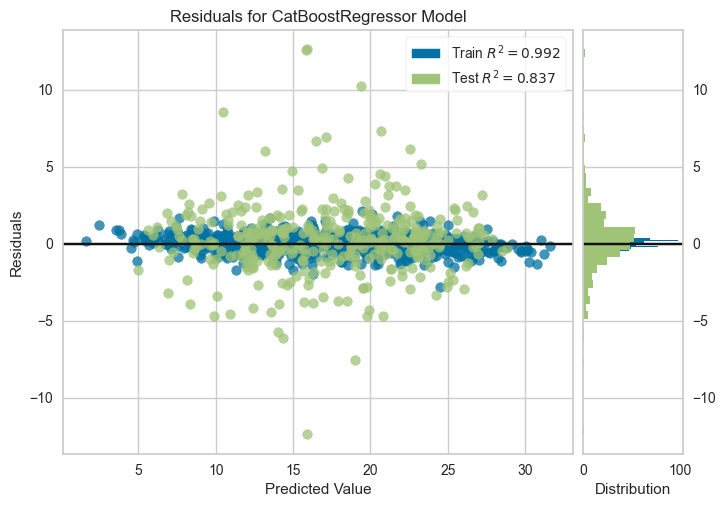

In [76]:
plot_model(best, plot = 'residuals')

In [77]:
plot_model(best, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

### Model Refinement

The above model represents a first pass at modelling the data. This iteration revealed several ways to improve the results of my model, which I will outline below.

In [78]:
predictions = predict_model(best, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.4752,4.4900,2.1190,0.8837,0.1429,0.1101


In [79]:
finalized_best = finalize_model(best)

#### Generating a table of Residuals

In [80]:
predictions = predict_model(finalized_best, data=data_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1.3839,4.0295,2.0074,0.8956,0.1289,0.1000


In [81]:
predictions['Residuals'] = predictions['cost_real_2023_transformed'] - predictions['prediction_label']
mean_res = np.mean(predictions['Residuals'])
std_res = np.std(predictions['Residuals'])
predictions['standardized_residuals'] = (predictions['Residuals'] - mean_res) / std_res

In [82]:
outliers = predictions.sort_values(by='standardized_residuals', key=abs, ascending=False)

In [83]:
outliers['standardized_residuals'].describe()

count    2.180000e+02
mean     2.037106e-17
std      1.002301e+00
min     -3.023893e+00
25%     -5.162284e-01
50%     -6.007355e-02
75%      4.231807e-01
max      5.559072e+00
Name: standardized_residuals, dtype: float64

In [84]:
outliers_list = outliers[abs(outliers['standardized_residuals'])>3].index.tolist()

In [85]:
len(outliers_list)

4

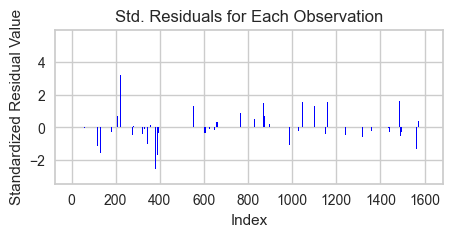

In [86]:
plt.figure(figsize=(5, 2))
plt.bar(outliers.index, outliers['standardized_residuals'], color='blue')
plt.xlabel('Index')
plt.ylabel('Standardized Residual Value')
plt.title('Std. Residuals for Each Observation')
plt.show()

#### Evaluating Outliers

Within the above interactive standardized residuals plot, three values are significant outliers and are labelled by index: r_###,r_###, and r_###. These residuals correspond to the index in my dataframe, however the index has been randomized during the data sampling process.

I've created a list of the 10 largest magnitude residuals in my dataset as a list called outliers_list.

Let's investigate these outliers.

The above outliers are all relatively short tunneling projects, which is a group of projects that I would expect to be difficult to model given the complexities and costs involved with tunneling.

In [87]:
outliers_df = df.loc[outliers_list]

By looking at the real cost (target feature) in our outliers list we can see that the largest residual also corresponds to the a real cost that is much higher than the rest of the values. Let's compare this outlier with the whole dataset to see if it's also an outlier.

In [88]:
def convert_str_to_float(val):
    if isinstance(val, str):
        return float(val.replace(',', ''))
    return val

df['cost_real_2023'] = df['cost_real_2023_transformed'].apply(convert_str_to_float)
df['track_gauge'] = df['track_gauge_transformed'].apply(convert_str_to_float)
df['union_density'] = df['union_density_transformed'].apply(convert_str_to_float)

In [89]:
df.sort_values(by = 'cost_real_2023_transformed',ascending = False).head(10)

,start_year,end_year,rr?,overhead?,anglo,cost_km_2023,train_type,project_type,region,sub_region,...,population_transformed,calculated_population_transformed,per_below_line_transformed,max_speed_transformed,reporting_gdp_transformed,prcp_transformed,track_gauge_transformed,cost_real_2023,track_gauge,union_density
924,2017,2025,0.0,0,0,551.376157,MRT,New,Asia,South-eastern Asia,...,174.371774,191.699955,2.816878,34.708785,22.802007,15.380294,6.241707e+06,32.055296,6.241707e+06,2.073268
1025,2019,2025,0.0,0,0,681.003619,MRT,New,Asia,South-eastern Asia,...,187.619554,207.694014,4.402224,27.800628,19.391153,18.589692,6.241707e+06,31.854077,6.241707e+06,3.969431
219,1993,2005,0.0,0,0,859.998345,MRT,New,Africa,Northern Africa,...,179.139969,178.390425,4.599042,34.708785,17.981078,6.031282,6.241707e+06,31.715755,6.241707e+06,7.116655
620,2012,2016,0.0,1,0,367.301779,MRT,New,Asia,Eastern Asia,...,173.517214,185.177337,4.424350,34.708785,21.653062,17.302811,6.241707e+06,31.449053,6.241707e+06,5.735043
1074,2015,2016,0.0,0,0,449.275436,MRT,New,Asia,Western Asia,...,141.887544,151.778738,3.929144,37.998656,31.562234,3.884947,6.241707e+06,30.955157,6.241707e+06,0.000000
1180,2020,2026,0.0,1,0,536.962304,MRT,New,Asia,Southern Asia,...,175.707954,196.855686,4.663347,41.199309,15.885165,17.962130,6.241707e+06,30.817156,6.241707e+06,4.557302
399,2016,2022,0.0,1,0,483.941723,MRT,New,Asia,Southern Asia,...,187.705918,205.314317,4.687721,34.708785,16.500249,18.357518,6.241707e+06,30.578363,6.241707e+06,4.813091
16,2012,2022,1.0,0,0,951.229242,MRT,Extension,Asia,Eastern Asia,...,142.824137,154.949235,3.243396,34.708785,24.587806,19.287930,6.241707e+06,30.559948,6.241707e+06,6.755671
334,2018,2025,1.0,1,0,372.489258,MRT,Extension,Asia,Eastern Asia,...,184.288349,202.320792,0.806993,64.558726,33.208558,14.746840,6.241707e+06,30.423254,6.241707e+06,4.217302
534,2011,2020,0.0,0,0,1009.615412,MRT,New,Asia,Eastern Asia,...,149.367017,162.223295,0.221730,37.998656,36.879892,19.061997,6.241707e+06,30.276565,6.241707e+06,9.377069


Notably, each of the outliers as shown in the residuals plot are also within the top 50 most expensive projects of the entire dataset. To correct this, I'll need to individually verify the values recorded for each project.

In [90]:
len(outliers_list)

4

#### Cooks Distance

In [91]:
categorical_columns = ['region', 'sub_region', 'train_type','project_type']
data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [92]:
data_encoded.columns = data_encoded.columns.str.replace('?', '').str.replace(' ', '_').str.replace('/', '_').str.replace(' ', '_').str.replace('-', '_')

In [93]:
formula = 'cost_real_2023_transformed ~ ' + ' + '.join([col for col in data_encoded.columns if col not in ['cost_real_2023_transformed']])
model = smf.ols(formula, data=data_encoded).fit()

influence = model.get_influence()
cooks_distance = influence.cooks_distance

data_encoded['cooks_distance'] = cooks_distance[0]

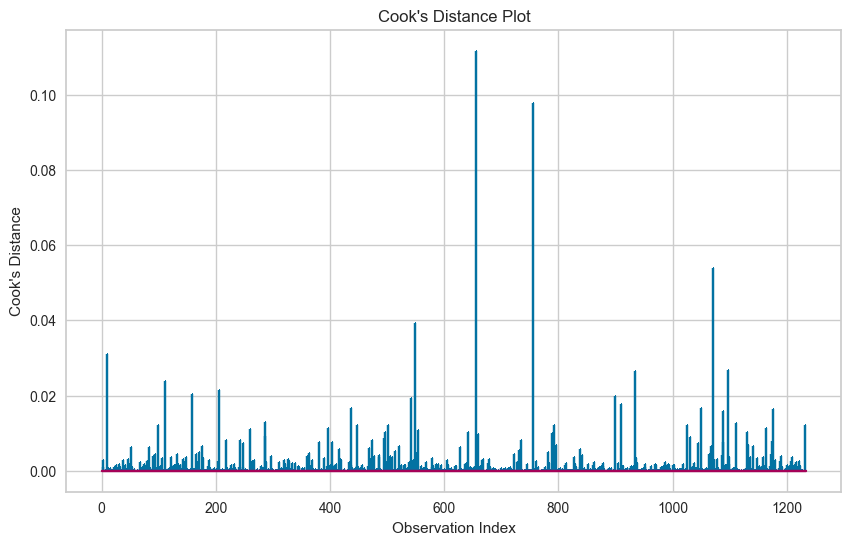

In [94]:
cooks_d = data_encoded['cooks_distance']

plt.figure(figsize=(10,6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",", use_line_collection=True)
plt.title('Cook\'s Distance Plot')
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.show()

As a general rule, a Cook's Distance greater than 1 should be investigated as a potential outlier. Given that I have previously removed outliers using z-score and IQR methods, I'll keep this conservative (for my data) method of evaluating cooks distance.

Since more conservative thresholds would highlight more points (using 4 times the mean), I'd like to simply remove exceptional outliers within the cook's plot.

In [95]:
df_cooks = df_cleaned[~df_cleaned.index.isin(cooks_d)]
df_cooks['cooks_d']= cooks_d

In [96]:
df_cooks.sort_values(by='cooks_d',ascending=False).head(3)

,start_year,end_year,rr?,overhead?,anglo,train_type,project_type,region,sub_region,wrb_class_value,...,length_transformed,stations_transformed,population_transformed,calculated_population_transformed,per_below_line_transformed,max_speed_transformed,reporting_gdp_transformed,prcp_transformed,track_gauge_transformed,cooks_d
1355,2020,2024,1.0,0,0,Streetcar,New,Americas,Latin America and the Caribbean,3.0,...,4.579609,4.035087,145.018015,159.051966,3.690755,31.315647,23.10922,11.528234,6.241707e+06,0.111681
1356,2014,2025,0.0,1,0,Light Rail,New,Americas,Latin America and the Caribbean,3.0,...,3.872199,3.928018,145.018015,157.994401,3.690755,31.315647,23.10922,11.528234,6.241707e+06,0.097908
215,2019,2025,0.0,0,0,MRT,New,Africa,Northern Africa,16.0,...,3.549882,3.155161,179.139969,198.197457,4.471556,34.708785,20.28092,6.031282,6.241707e+06,0.053781


Since the project in Lagos is by far the largest value, I'll remove this singular datapoint.

In [97]:
df_cleaned.drop(index =(df_cooks.sort_values(by='cooks_d',ascending=False).head(3)).index,inplace=True)

### Interpreting Residuals v. Leverage Plot

The Residuals vs. Leverage plot provides insight into the influence of individual observations on the model's estimates. Points with high leverage have a large potential to influence the fit of the model, while points with high residuals do not fit the model well. 

Observations that are situated in the top right or bottom right corners of the plot—meaning they have both high leverage and high residuals—are particularly influential and may be of concern. They might indicate outliers, leverage points, or both and could potentially distort the model's predictions. Monitoring these points can help improve the model's robustness and accuracy.

In [98]:
plot_model(best, plot = 'residuals_interactive')

    'data': [{'hovertemplate': 'Split=train<br>Predictions…

### Outlier Removal

In the next sheet, I'll be evaluating the outliers gathered from the first run of the model and that were stored in the outliers_list.

In [99]:
len(outliers_list)

4

### Model Summary

In [100]:
data_summary = {
    'Model': [
        'Model First Pass'
    ],
    'Version': ['M_A1'],
    'Dataset': ['Base df'],
    'MAE': [1.5320],
    'MSE': [4.8763],
    'RMSE': [2.2082],
    'R2': [0.8737],
    'RMSLE': [0.1459],
    'MAPE': [0.1133]
}

combined_metrics = pd.DataFrame(data_summary)

In [101]:
combined_metrics

,Model,Version,Dataset,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Model First Pass,M_A1,Base df,1.532,4.8763,2.2082,0.8737,0.1459,0.1133


In [102]:
df_cleaned['cost_real_2023'] = df_cost['cost_real_2023']

### Pickles

In [103]:
with open('pickles/outliers_list.pkl', 'wb') as f:
    pickle.dump(outliers_list, f)
with open('pickles/combined_metrics.pkl', 'wb') as f:
    pickle.dump(combined_metrics, f)
with open('pickles/df_cleaned.pkl', 'wb') as f:
    pickle.dump(df_cleaned, f)
with open('pickles/df_cost.pkl', 'wb') as f:
    pickle.dump(df_cost, f)
with open('pickles/lambdas_dict.pkl', 'wb') as f:
    pickle.dump(lambdas_dict, f)